# Wait Wait, Don't Analyze Me!

![NPR logo](https://media.npr.org/branding/programs/wait-wait-dont-tell-me/branding_main-c5920a167d6a5d445ce86fac30b90454223b6b57.png "One nerd's attempt to learn everything there is to know about NPR's greatest quiz show.")


# Introduction
[Wait Wait, Don't Tell Me!](https://www.npr.org/programs/wait-wait-dont-tell-me/) is NPR's longest-running news quiz show. Contestents call in to answer questions about the week's news, and a rotating cast of three panelists make jokes and parody newsworthy (and not-so-newsworthy) current events. Listening to "Wait wait" has been a highlight of my week since I was a kid, and it remains one of NPR's most popular segments. So what better way to show my appreciation than to take it apart and see what makes it tick?

For this project, I have pulled text transcripts of each episode of "Wait, Wait", storing them as a MySQL library. I have two goals:
1. Understand and predict jokes in the program.
2. Create a "Wait wait" transcript generator, so that I don't have to wait a whole week between episodes!

# Section 0: Initial data exploration

## 0.1 Loading the data
Before I can analyze the data, I must first load it and process it. To accomplish this, I wrote a simple function to load in text files containing the transcripts, figure out who the speakers are, and separate the text blocks into a list of words.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
import mysql.connector

%matplotlib inline

# change the default font size in figures to be larger
font = {'size'   : 15}

plt.rc('font', **font)

Using TensorFlow backend.


In [2]:
# connect to the database of wait wait don't tell me transcripts
cnx = mysql.connector.connect(database='wait_wait',
                              user='root')

In [3]:
# function to pull some transcripts from the database
def pull_transcript(n=5):
    # instantiate a cursor to select data from the database
    curs = cnx.cursor()
    curs.execute(f'select * from transcripts limit {n}')
    
    # pull the data and convert to a pandas dataframe
    df = pd.DataFrame(data = np.array(curs.fetchmany(n)),columns=curs.column_names)
    df = df.set_index('id')
    
    # close the cursor
    curs.close()
    return df

In [4]:
transcript_df = pull_transcript(n=1500)
transcript_df.tail()

,episode_id,aired_at,url,segment,transcript
id,,,,,
1496,200,2016-01-30,https://www.npr.org/templates/transcript/trans...,panel,\n \n \n \n\n BILL KURTIS: Fro...
1497,200,2016-01-30,https://www.npr.org/templates/transcript/trans...,limerick,"\n \n \n \n\n MIKE PESCA, HOST..."
1498,200,2016-01-30,https://www.npr.org/templates/transcript/trans...,lightning,"\n \n \n \n\n MIKE PESCA, HOST..."
1499,200,2016-01-30,https://www.npr.org/templates/transcript/trans...,predictions,"\n \n \n \n\n MIKE PESCA, HOST..."
1500,201,2016-01-30,https://www.npr.org/templates/transcript/trans...,who,\n \n \n \n\n BILL KURTIS: Fro...


In [5]:
# function to load and process one text files
def Process_Transcript(ID):
    # Load the file
    transcript = transcript_df.loc[ID,'transcript']

    # split the text into words
    words = transcript.split()
    while not words[0][-1] == ':': # remove intro text before the first speaker
        words = words[1:]
    
    # Iterate through all of the words, and find those that correspond to speakers
    names = set([x for x in words if x[-1]==':']) 
    return words, names

## 0.2 Example transcript

Let's print a little bit of the transcript from the first dataset, and see what it looks like.

In [57]:
print(transcript_df.loc[1,'transcript'][:500])


    
        
    

    BILL KURTIS: From NPR and WBEZ Chicago, this is WAIT WAIT... DON'T TELL ME, the NPR news quiz. Hey, Arthur Miller - step into this Cruci-Bill (ph).
    (LAUGHTER)
    KURTIS: I'm Bill Kurtis. And here's your host at the Chase Bank Auditorium in downtown Chicago, Peter Sagal.
    PETER SAGAL, HOST: 
    Thank you, Bill. Thank you, everybody.
    (CHEERING)
    SAGAL: Thank you so much. We have a very interesting show for you today. Later on, we're going to be talking to M


In [58]:
transcript_df.loc[1,'transcript'][:1000]

"\n    \n        \n    \n\n    BILL KURTIS: From NPR and WBEZ Chicago, this is WAIT WAIT... DON'T TELL ME, the NPR news quiz. Hey, Arthur Miller - step into this Cruci-Bill (ph).\n    (LAUGHTER)\n    KURTIS: I'm Bill Kurtis. And here's your host at the Chase Bank Auditorium in downtown Chicago, Peter Sagal.\n    PETER SAGAL, HOST: \n    Thank you, Bill. Thank you, everybody.\n    (CHEERING)\n    SAGAL: Thank you so much. We have a very interesting show for you today. Later on, we're going to be talking to Microsoft co-founder Steve Ballmer. He is, we believe, the richest guest we've ever had. But, of course, your true wealth is measured in your friends. And this just in - he has more friends, too.\n    (LAUGHTER)\n    SAGAL: But first, as many of you know, the NPR podcast feeds got all screwed up last week. People who tried to download our show got, for example, How I Built This instead, for which I apologize. And the people who wanted How I Built This got us, for which I apologize eve

Initially, we can note a number of features. First, audience responses are noted with the '(LAUGHTER)' marker and '(APPLAUSE)' marker. This will prove very useful, as we have an automatic metric for "funniness" of the preceding text. 

Speakers' names are in all caps, followed by a colon. Speakers are also separated by a line break and a tab, which could potentially be used to segment the text into phrases by various people. 

Let's look at some properties of the transcript. For example, we can look at the distribution of line lengths.

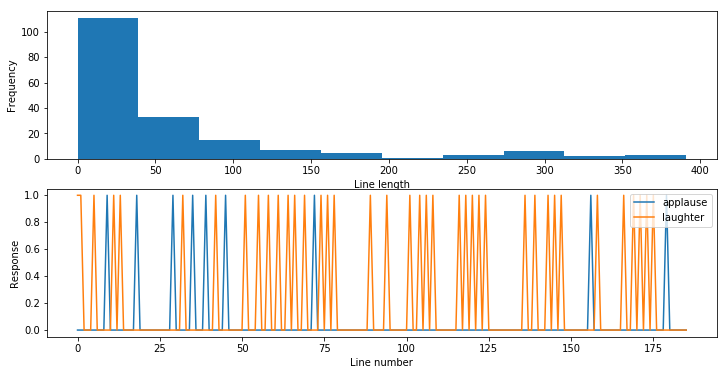

In [59]:
def count_line_length(transcript):
    by_lines = transcript.split('\n    ')
    line_len = np.zeros(len(by_lines))
    applause = np.zeros(len(by_lines))
    laughter = np.zeros(len(by_lines))
    for idx,line in enumerate(by_lines):
        line_len[idx] = len(line)
        applause[idx] = line in ('(CHEERING)','(APPLAUSE)')
        laughter[idx] = line in ('(LAUGHTER)')
        
    return line_len,applause,laughter

example_transcript = transcript_df.loc[1,'transcript']
line_len,applause,laughter = count_line_length(example_transcript)

plt.figure(figsize=(12,6))
plt.subplot(2,1,1);
plt.hist(line_len);
plt.xlabel('Line length')
plt.ylabel('Frequency')

plt.subplot(2,1,2);
plt.plot(applause);
plt.plot(laughter)
plt.xlabel('Line number')
plt.ylabel('Response')
plt.legend(['applause','laughter'],loc='upper right')

So we can see that there are a lot of short lines and a long tail of longer lines, presumably corresponding to news stories and the like. There are a few confounding factors here. First, presumably a number of the shorter lines are also the laughter and applause markers. Second, the speaker identity is itself counting toward the line lenghth. 

It's probably worth doing a little more processing on these lines, dividing them by speaker, and giving them a marker for applause and laughter if they are followed by applause or laughter. 

In [75]:
transcript = transcript_df.loc[1,'transcript']
by_lines = transcript.split('\n    ')
df = pd.DataFrame(by_lines,columns=['lines'])
df.shape

(186, 1)

In [267]:
def line_info(transcript_number):
    transcript = transcript_df.loc[transcript_number,'transcript'];
    by_lines = transcript.split('\n    ')
    df = pd.DataFrame(by_lines,columns=['lines']) # turn the lines into a dataframe
    
    # if the line contains "APPLAUSE", mark the previous line as "clapping"
    # if the line contains "LAUGHTER", mark the previous line as "funny"
    df['funny'] = False
    df['clapping'] = False
    df.loc[np.where(df.lines=='(LAUGHTER)')[0]-1,'funny'] = True
    df.loc[np.where(df.lines=='(APPLAUSE)')[0]-1,'funny'] = True
    df.loc[np.where(df.lines=='(CLAPPING)')[0]-1,'funny'] = True
    df.loc[np.where(df.lines=='(CHEERING)')[0]-1,'funny'] = True
    
    # for the remaining lines, identify the speaker
    df['speaker'] = ''
    speaker_re = re.compile('[A-Z]+:'); # regular expression to find all-caps word followed by a colon
    full_speaker_re = re.compile('^(.*?)[A-Z]+: ') # find all-caps word followed by a colon, and all words preceding
    for idx,line in zip(df.index,df.lines):
        try:
            df.loc[idx,'speaker'] = speaker_re.search(line).group()[:-1]
            df.loc[idx,'lines'] = full_speaker_re.sub('',line)
            
            if df.loc[idx,'speaker'] == 'HOST':
                df.loc[idx+1,'speaker'] = 'SAGAL'
                df.loc[idx,'speaker'] = ''
        except:
            continue
    
    # drop the lines with no speaker
    rows_to_remove = df.index[np.where((df.speaker==''))[0]]
    df = df.drop(rows_to_remove)
    
    return df

In [274]:
# show an example processed transcript
df = line_info(117)
df

,lines,funny,clapping,speaker
5,Now onto our final game - Lightning Fill In Th...,False,False,SAGAL
6,Faith and Paula each have two. Tom has three.,False,False,KURTIS
7,"Ooh, Tom. Yay. All right. We flipped a coin. F...",False,False,SAGAL
8,Michael Cohen.,False,False,SALIE
9,Right.,False,False,SAGAL
11,"On Sunday, the White House announced it was de...",False,False,SAGAL
12,Tariff.,False,False,SALIE
13,Right.,False,False,SAGAL
15,"This week, the House passed a bill calling for...",False,False,SAGAL
16,Background checks.,False,False,SALIE


In [269]:
df.loc[14,'lines']

'You certainly did. PETA has issued vegan-friendly updates to a number of animal-unfriendly phrases, including changing kill two birds with one stone to feed two birds with one scone...'

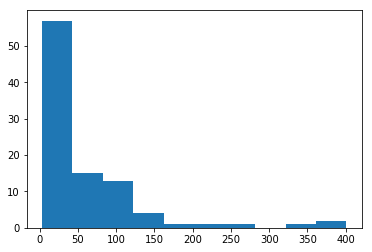

In [275]:
plt.hist(df.lines.str.len());

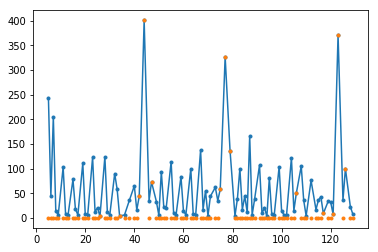

In [281]:
plt.plot(df.lines.str.len(),'.-')
plt.plot(df.funny*df.lines.str.len(),'.')

# Section 1: Understanding jokes

### 1.1 Who is the funniest panelist? 

The first question I address is which panelist is the funniest. I'm aided in this process by the fact that laughter is marked in the transcripts, with the label "(LAUGHTER)". Thus, I can look at every laugh, and figure out who caused it. But people who talk more are likely to get more laughs than those who don't talk much, on average. So, I will calculate the "**Laugh rate**," defined as the number of laughs each speaker gets per hundred words they speak. I will save my results in a pandas table.

In [75]:
# generate an empty pandas dataframe to keep track of the results
df = pd.DataFrame(index=[], columns=['num_words','num_segments','num_laughs','num_claps'])
df = df.fillna(0)

# for each transcript, count the words spoken and the number of laughs
for ID in transcript_df.index:
    words, names = Process_Transcript(ID)
    
    # increment the number of segments this person has been seen in
    for speaker in names:
        if speaker == 'HOST:': # Peter Sagal is sometimes referred to as "Host"
            speaker = 'SAGAL:'
        if speaker not in df.index: # add a row if we haven't seen this speaker before
            df.loc[speaker,:] = 0
        df.loc[speaker,'num_segments'] +=1
        continue
    
    # Count the number of words each person says, and the number of laughs they receive
    for word in words:
        # note each time the speaker changes
        if word in names:
            speaker = word
            if speaker == 'HOST:': # Peter Sagal is sometimes referred to as "Host"
                speaker = 'SAGAL:'
            continue
        
        # count laughs
        if 'LAUGHTER' in word:
            df.loc[speaker,'num_laughs'] +=1
            continue
        
        # count applause
        if 'APPLAUSE' in word:
            df.loc[speaker,'num_claps'] +=1
            continue
        
        # count total words
        df.loc[speaker,'num_words'] +=1
        
    # report progress
    if ID % 100 == 0:
        print(ID)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [108]:
df.describe() # some summary statistics on the data

,num_words,num_segments,num_laughs,num_claps,laughs_per_word,laughs_per_segment,clap_rate
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,25894.631579,152.736842,365.877193,100.877193,1.817089,1.981153,0.345150
std,130169.897096,421.592835,1621.403009,483.336879,0.904443,1.437863,0.207279
min,516.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,898.000000,8.000000,13.000000,2.000000,1.228879,1.181818,0.217865
50%,2951.000000,26.000000,70.000000,10.000000,1.880890,1.625000,0.338868
75%,14837.000000,107.000000,199.000000,45.000000,2.347780,2.267857,0.422238
max,985744.000000,2928.000000,12293.000000,3618.000000,4.000000,6.307692,1.043219


/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


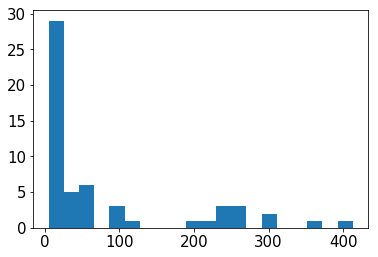

In [103]:
plt.hist(df.num_segments[df.num_segments <1000],bins=20);

We should do some data cleanup at this juncture. In particular, there are may speakers with very few words, or who appear on a single segment. This is because each "call in" gets assigned to a particular speaker. Each show also has a guest speaker, who typically only appears on the "not my job segment. So let's go ahead and remove entries where the speaker appears in under 5 segments, or speaks very few words.

In [109]:
# remove the speakers with less than 2000 words (call-in guests and the like)
df = df[df['num_segments'] > 10]
df = df[df['num_words'] > 500]

In [110]:
# Now divide the number of laughs by the number of words to get the laugh rate (laughs per hundred words)
df['laughs_per_word'] = 100*df['num_laughs']/df['num_words']
df['laughs_per_segment'] = df['num_laughs']/df['num_segments']
df['clap_rate'] = 100*df['num_claps']/df['num_words']
df.sort_values('laughs_per_word',ascending=False)

,num_words,num_segments,num_laughs,num_claps,laughs_per_word,laughs_per_segment,clap_rate
GOLDTHWAIT:,4516.0,53.0,151.0,7.0,3.343667,2.849057,0.155004
PAPA:,2124.0,26.0,70.0,14.0,3.295669,2.692308,0.659134
JR:,2951.0,55.0,91.0,10.0,3.083700,1.654545,0.338868
KONDABOLU:,4291.0,56.0,127.0,17.0,2.959683,2.267857,0.396178
HIGGINS:,4322.0,42.0,125.0,15.0,2.892180,2.976190,0.347062
JR.:,4041.0,107.0,116.0,15.0,2.870577,1.084112,0.371195
O'ROURKE:,4143.0,58.0,114.0,14.0,2.751629,1.965517,0.337919
ADEWUNMI:,3625.0,48.0,94.0,13.0,2.593103,1.958333,0.358621
POUNDSTONE:,42223.0,413.0,1090.0,163.0,2.581531,2.639225,0.386046
BURKE:,16167.0,201.0,403.0,55.0,2.492732,2.004975,0.340199


/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


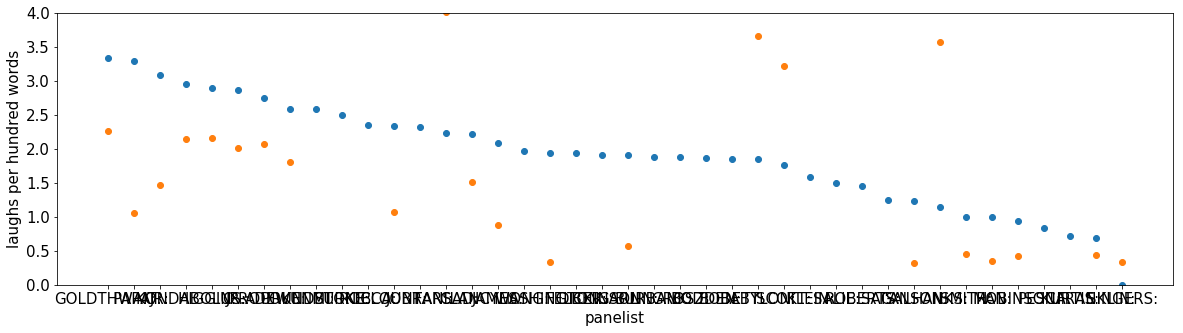

In [111]:
plt.figure(figsize=(20,5));
plt.plot(df.sort_values('laughs_per_word',ascending=False).laughs_per_word,'o');
plt.xlabel('panelist');
plt.ylim([0,np.ceil(df.laughs_per_word.max())])
plt.ylabel('laughs per hundred words');

/Users/coraames/git/BimanualModeling/py_36_env/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


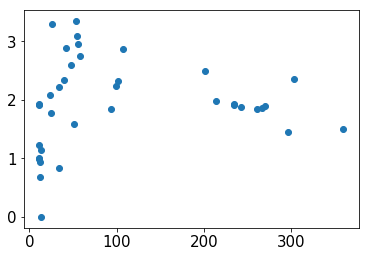

In [115]:
plt.scatter(df.num_segments[df.num_segments<400],df.laughs_per_word[df.num_segments<400])

### Conclusions, further questions
It looks like our winner is Helen Hong! With 3.5 laughs per hundred words, Hong leaves runner-up Jessi Klein in the dust. 
Looking at our data table, we can also see that Helen Hong has fewer total words spoken than others. Alternatively, if we have fewer samples that might tend to lead to noisier estimates for the people who talk less, leading them to have more variance in the estimate of "funniness." Might how much a person talks be negatively related to funniness? Or do shorter digressions tend to be funnier? What other properties can predict laughter?

### Questions to address:
1. What are the funniest words? 
    - Examine the words that precede laughs, look for trends.
    - Weight by word frequency in whole show. (percent of time the word elicited a laugh)
    - Eliminate "common" words (the, and, ...)
2. Build a laugh predictor:
    - Based on a set of words
    - RNN
    - Markov model?

### 1.2 What are the funniest words?

In our quest to predict laughter, one reasonable thing to consider is which words or phrases tend to precede laughs. Are there any major trends in these words? To do this, I will count all of the words that precede laughter, and compare it with total word counts.

In [ ]:
# Store the data in a dictionary
all_words = {}
funny_words = {}

In [116]:
# start out by processing one transcript
transcript_df.loc[1,'transcript']

'\n    \n        \n    \n\n    BILL KURTIS: From NPR and WBEZ Chicago, this is WAIT WAIT... DON\'T TELL ME, the NPR news quiz. Hey, Arthur Miller - step into this Cruci-Bill (ph).\n    (LAUGHTER)\n    KURTIS: I\'m Bill Kurtis. And here\'s your host at the Chase Bank Auditorium in downtown Chicago, Peter Sagal.\n    PETER SAGAL, HOST: \n    Thank you, Bill. Thank you, everybody.\n    (CHEERING)\n    SAGAL: Thank you so much. We have a very interesting show for you today. Later on, we\'re going to be talking to Microsoft co-founder Steve Ballmer. He is, we believe, the richest guest we\'ve ever had. But, of course, your true wealth is measured in your friends. And this just in - he has more friends, too.\n    (LAUGHTER)\n    SAGAL: But first, as many of you know, the NPR podcast feeds got all screwed up last week. People who tried to download our show got, for example, How I Built This instead, for which I apologize. And the people who wanted How I Built This got us, for which I apologiz

In [119]:
def transcriptToFreqDict(transcript):
    wordlist = transcript.split()
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(zip(wordlist,wordfreq))

In [120]:
transcriptToFreqDict(transcript_df.loc[1,'transcript'])

{'BILL': 1,
 'KURTIS:': 7,
 'From': 1,
 'NPR': 5,
 'and': 26,
 'WBEZ': 1,
 'Chicago,': 2,
 'this': 22,
 'is': 24,
 'WAIT': 2,
 'WAIT...': 2,
 "DON'T": 2,
 'TELL': 2,
 'ME,': 1,
 'the': 62,
 'news': 1,
 'quiz.': 1,
 'Hey,': 4,
 'Arthur': 1,
 'Miller': 1,
 '-': 18,
 'step': 1,
 'into': 2,
 'Cruci-Bill': 1,
 '(ph).': 4,
 '(LAUGHTER)': 37,
 "I'm": 8,
 'Bill': 4,
 'Kurtis.': 1,
 'And': 14,
 "here's": 3,
 'your': 8,
 'host': 1,
 'at': 6,
 'Chase': 1,
 'Bank': 1,
 'Auditorium': 1,
 'in': 14,
 'downtown': 1,
 'Peter': 2,
 'Sagal.': 1,
 'PETER': 2,
 'SAGAL,': 1,
 'HOST:': 1,
 'Thank': 5,
 'you,': 3,
 'Bill.': 1,
 'everybody.': 1,
 '(CHEERING)': 2,
 'SAGAL:': 70,
 'you': 32,
 'so': 7,
 'much.': 1,
 'We': 1,
 'have': 7,
 'a': 28,
 'very': 1,
 'interesting': 2,
 'show': 3,
 'for': 16,
 'today.': 1,
 'Later': 1,
 'on,': 1,
 "we're": 3,
 'going': 5,
 'to': 35,
 'be': 5,
 'talking': 4,
 'Microsoft': 1,
 'co-founder': 1,
 'Steve': 1,
 'Ballmer.': 1,
 'He': 4,
 'is,': 4,
 'we': 4,
 'believe,': 1,
 'ric

# How is laughter distributed through a show?

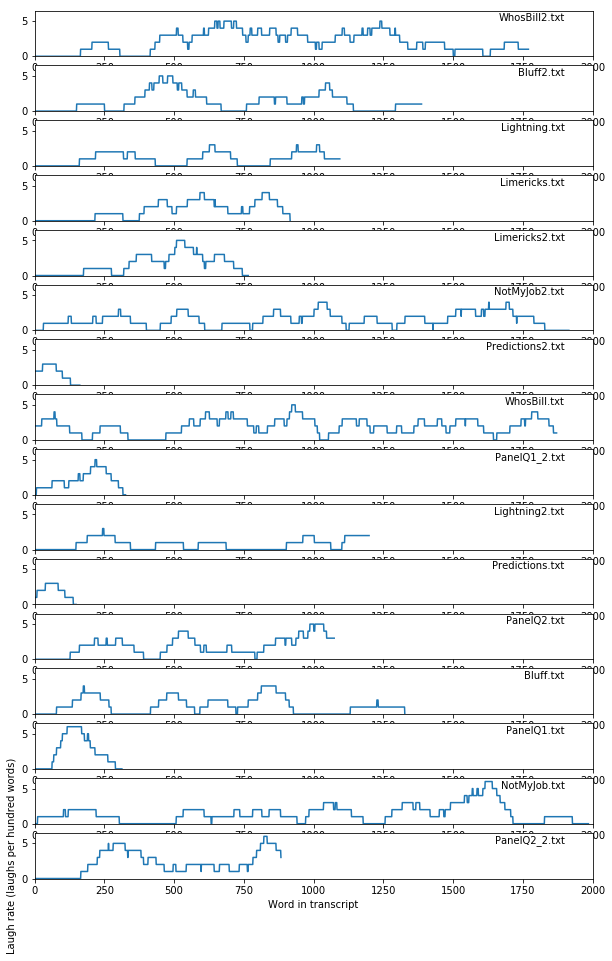

In [41]:
plt.figure(figsize=(10,20))
for file_idx,file in zip(range(len(files)),files):
    words, names,transcript = Load_Transcript(data_dir+file)
    
    # note where in the transcript laughs occured
    laughs = np.zeros(len(words))
    speaker_change = np.zeros(len(words))
    for word_idx, word in zip(range(len(words)), words):
        if 'LAUGHTER' in word:
            laughs[word_idx] = 1
    plt.subplot(20,1,file_idx+1)
    plt.plot(np.convolve(laughs,np.ones(100),mode='same'))
    plt.xlim([0,2000])
    plt.ylim([0, 6.5])
    plt.text(1900,5,file,ha='right')

plt.xlabel('Word in transcript');
plt.ylabel('Laugh rate (laughs per hundred words)');

# Can we create our own Wait Wait Don't Tell Me content?

In [9]:
# Load all of the transcripts
transcript_list = []
chars = set()
for file in files:
    _,_,transcript = Load_Transcript(data_dir+file)
    transcript_list.append(transcript)


In [10]:
# build a tokenizer to convert the words to integers
vocab_size = 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',split=' ')
tokenizer.fit_on_texts(transcript_list)
encoded_transcripts = tokenizer.texts_to_sequences(transcript_list)

In [250]:
help(tokenizer.sequences_to_texts)

Help on method sequences_to_texts_generator in module keras_preprocessing.text:

sequences_to_texts_generator(sequences) method of keras_preprocessing.text.Tokenizer instance
    Transforms each sequence in `sequences` to a list of texts(strings).
    
    Each sequence has to a list of integers.
    In other words, sequences should be a list of sequences
    
    Only top "num_words" most frequent words will be taken into account.
    Only words known by the tokenizer will be taken into account.
    
    # Arguments
        texts: A list of sequences.
    
    # Yields
        Yields individual texts.



In [14]:
tokenizer.sequences_to_texts([encoded_transcripts[1]])

["bill kurtis from npr and wbez chicago this is wait wait don't tell me the npr news quiz cheering kurtis i'm bill kurtis we're playing this week with jessi klein helen hong and luke burbank and here again is your host at the san diego civic theatre in san diego calif peter sagal peter sagal host thank you bill thank you everybody cheering sagal right now it is time for the wait wait don't tell me bluff the listener game call 1 888 wait wait to play our game on the air hi you are on wait wait don't tell me carrie phillips hi peter this is carrie phillips and i'm calling from corvallis ore sagal oh corvallis it's beautiful up there cheering phillips yes it is sagal what do you do up there phillips well i'm fairly recently retired and so i spend most of my time doing all those things you don't have time for when you work sagal there you go what sort of things are you spending your time doing now that you don't have to work phillips hiking paddling road trips doing the crossword puzzle yo

In [15]:
# split up the model
train_len = 50
x = []
y = []
for transcript in encoded_transcripts:
    for word in range(0,len(transcript)-train_len-1,3):
        x.append(transcript[word:word+train_len])
        y.append(transcript[word+train_len+1])
x = np.array(x)
y = np.array(y)

from keras.utils import to_categorical
y_binary = to_categorical(y,num_classes=vocab_size)

In [39]:
# build the model
model = keras.Sequential()
model.add(Embedding(vocab_size, 28, input_length=train_len))
model.add(GRU(128))
model.add(Dense(vocab_size, activation='softmax'))

optimizer = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 28)            280000    
_________________________________________________________________
dense_6 (Dense)              (None, 50, 10000)         290000    
Total params: 570,000
Trainable params: 570,000
Non-trainable params: 0
_________________________________________________________________


In [40]:
# print_callback = LambdaCallback(on_epoch_end=on_epoch_end
history = model.fit(x, y_binary,
              batch_size=128,
              epochs=5,
              validation_split=.1,
              shuffle = True,
    #           callbacks=[on_epoch_end]
             )

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

ValueError: Error when checking target: expected dense_6 to have 3 dimensions, but got array with shape (5467, 10000)

In [18]:
from numpy import random
import sys

In [26]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(len(x))
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)
        
        
        generated_decoded = ''
        sentence = x[start_index]
        generated_encoded = sentence
        generated_decoded += tokenizer.sequences_to_texts([sentence])[0]
        print('----- Generating with seed: "' + generated + '"')

        for i in range(400):
            x_pred = generated_encoded[-train_len:]
            
            preds = model.predict(x_pred, verbose=0)[0]
            
            next_index = sample(preds, diversity)
            next_char = num_to_char[next_index]

            generated += next_char
            sentence = generated[-train_len:]

        print(generated)


In [21]:
generated_decoded = ''
sentence = x[10]
generated_encoded = sentence
generated_decoded += tokenizer.sequences_to_texts([sentence])[0]
print('----- Generating with seed: "' + generated + '"')


for i in range(400):
    x_pred = generated_encoded[-train_len:]
    preds = model.predict(x_pred, verbose=0)


NameError: name 'generated' is not defined

In [23]:
x_pred = generated_encoded[-train_len:]
x_pred.shape

(50,)

In [24]:
model.predict(x_pred)

ValueError: Error when checking input: expected embedding_1_input to have shape (50,) but got array with shape (1,)

In [279]:
x

array([[  50,   41,   42, ...,  106,    7,   50],
       [ 139,    6,  340, ...,  193,    2,  106],
       [ 178,   17,   11, ...,    7,  194,  195],
       ...,
       [  16,    1, 2892, ...,    8,   57,   33],
       [   5,    1, 1176, ...,   78,   12,   24],
       [2893, 2894,    8, ...,  280, 2896, 1162]])